# Auditoría simulada de accesos a sistemas

Este proyecto simula un análisis de auditoría IT centrado en accesos de usuarios a un sistema corporativo. El objetivo es detectar patrones de riesgo y posibles brechas de control interno, como accesos fuera de horario laboral, actividad de usuarios inactivos, o excesos de intentos fallidos de inicio de sesión.

El análisis se realiza sobre datos ficticios con técnicas básicas de auditoría, pensamiento analítico y visualización de datos.

📌 **Tecnologías utilizadas:**  
- Python (pandas, matplotlib, seaborn)  
- Datos simulados en formato CSV  
- Estilo consultoría/auditoría 


In [1]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración estética
sns.set(style='whitegrid')

In [2]:
# Carga de datos
accesos = pd.read_csv('accesos_simulados.csv')
usuarios = pd.read_csv('usuarios.csv')

accesos['timestamp'] = pd.to_datetime(accesos['timestamp'])
accesos.head()

,user_id,timestamp,action,ip_address,is_successful
0,u007,2025-07-01 00:00:00,login,192.168.1.54,True
1,u020,2025-07-01 01:00:00,logout,192.168.1.118,True
2,u015,2025-07-01 02:00:00,logout,192.168.1.3,True
3,u011,2025-07-01 03:00:00,file_access,192.168.1.144,True
4,u008,2025-07-01 04:00:00,logout,192.168.1.215,True


## Análisis 1: Accesos fuera de horario laboral

Uno de los controles básicos en auditoría IT es verificar accesos realizados fuera del horario laboral habitual, ya que pueden ser indicio de actividades no autorizadas o negligencia en el uso de credenciales.

En este caso, consideramos "fuera de horario" todo acceso registrado **antes de las 7:00 h o después de las 20:00 h**.


Total accesos registrados: 300
Accesos fuera de horario laboral: 127

Usuarios con más accesos fuera de horario:
user_id
u003    12
u017    11
u007    10
u016     9
u001     8
Name: count, dtype: int64


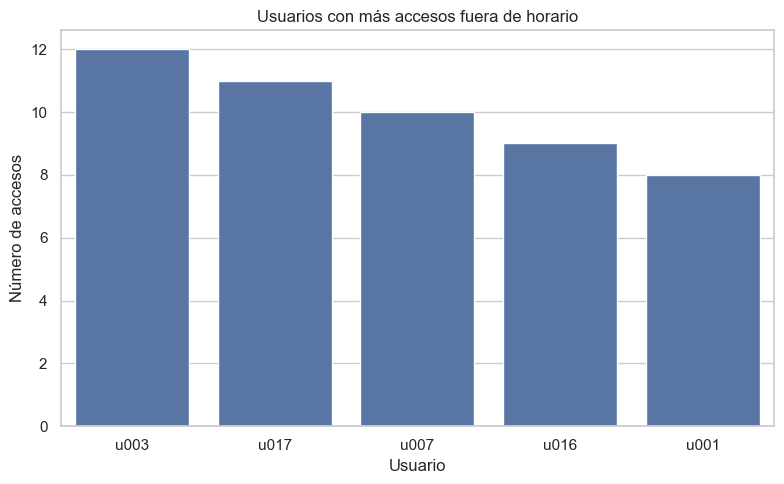

In [6]:
# Extraer la hora de cada acceso
accesos['hora'] = accesos['timestamp'].dt.hour

# Definir accesos fuera de horario
fuera_horario = accesos[(accesos['hora'] < 7) | (accesos['hora'] > 20)]

# Mostrar resumen
print(f"Total accesos registrados: {len(accesos)}")
print(f"Accesos fuera de horario laboral: {len(fuera_horario)}")

# Top 5 usuarios con más accesos fuera de horario
top_fuera = fuera_horario['user_id'].value_counts().head()
print("\nUsuarios con más accesos fuera de horario:")
print(top_fuera)

# Gráfico de accesos fuera de horario por usuario (top 5)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=top_fuera.index, y=top_fuera.values)
plt.title('Usuarios con más accesos fuera de horario')
plt.xlabel('Usuario')
plt.ylabel('Número de accesos')
plt.tight_layout()
plt.show()

### Interpretación de hallazgos

Se han registrado un total de **127 accesos fuera del horario laboral** (antes de las 07:00 h o después de las 20:00 h), lo que representa aproximadamente el **42 % del total de accesos**. Este volumen es considerable y puede reflejar desde necesidades legítimas de ciertos departamentos hasta posibles hábitos de uso indebido de credenciales.

Los cinco usuarios con más accesos en este rango horario son:  
- `u003` (12 accesos)  
- `u017` (11 accesos)  
- `u007` (10 accesos)  
- `u016` (9 accesos)  
- `u001` (8 accesos)

Estos patrones deben ser revisados con detalle para comprobar si responden a funciones justificadas (por ejemplo, soporte técnico nocturno) o si requieren una revisión de políticas de acceso.

📌 **Recomendación:** establecer alertas automáticas para accesos fuera del horario habitual y revisar las funciones y permisos de los usuarios con mayor frecuencia en franjas críticas.


## Análisis 2: Actividad de usuarios inactivos

Es fundamental garantizar que las cuentas inactivas no permanezcan activas ni generen actividad en los sistemas, ya que esto representa un riesgo potencial de uso indebido o suplantación de identidad.

A continuación, se analiza si existen accesos realizados por usuarios que figuran como inactivos en el sistema de referencia.


In [7]:
# Filtrar usuarios inactivos según el archivo de usuarios
usuarios_inactivos = usuarios[usuarios['is_active'] == False]
ids_inactivos = usuarios_inactivos['user_id'].tolist()

# Buscar accesos realizados por esos usuarios
actividad_inactivos = accesos[accesos['user_id'].isin(ids_inactivos)]

# Mostrar resultados
print(f"Total de usuarios marcados como inactivos: {len(ids_inactivos)}")
print(f"Accesos realizados por usuarios inactivos: {len(actividad_inactivos)}")

# Ver detalle de esos accesos
actividad_inactivos[['user_id', 'timestamp', 'action', 'ip_address']].head()


Total de usuarios marcados como inactivos: 1
Accesos realizados por usuarios inactivos: 17


,user_id,timestamp,action,ip_address
13,u012,2025-07-01 13:00:00,file_access,192.168.1.204
17,u012,2025-07-01 17:00:00,file_access,192.168.1.8
18,u012,2025-07-01 18:00:00,logout,192.168.1.122
25,u012,2025-07-02 01:00:00,config_change,192.168.1.178
42,u012,2025-07-02 18:00:00,file_access,192.168.1.240


### Interpretación de hallazgos

Se ha identificado **1 usuario marcado como inactivo (`u012`)** en el sistema, el cual ha realizado un total de **17 accesos** tras haber sido desactivado, incluyendo acciones sensibles como `file_access` y `config_change`.

Algunos accesos ocurren incluso en horarios nocturnos (por ejemplo, a la 01:00 h del 2 de julio), lo que podría indicar una actividad no autorizada o una mala gestión del ciclo de vida de cuentas.

Este comportamiento supone un **riesgo claro de seguridad**, ya que las cuentas inactivas deberían estar deshabilitadas por defecto, y cualquier actividad posterior a la desactivación debería generar una alerta inmediata.

📌 **Recomendación:**  
- Revisar la política de gestión de cuentas inactivas.  
- Asegurar el cierre completo de accesos para cuentas deshabilitadas.  
- Implementar monitoreo automatizado para accesos de usuarios fuera de estado activo.


## Análisis 3: Fallos de inicio de sesión

Una cantidad elevada de intentos de acceso fallidos puede ser indicativa de:
- Problemas de acceso legítimo (usuarios olvidando contraseñas)
- Intentos de suplantación o fuerza bruta
- Fallos de sincronización entre sistemas de autenticación

Aquí analizamos qué usuarios acumulan más fallos de login.


Total de intentos de login fallidos: 61

Usuarios con más fallos de login:
user_id
u019    7
u012    5
u002    5
u003    5
u005    4
Name: count, dtype: int64


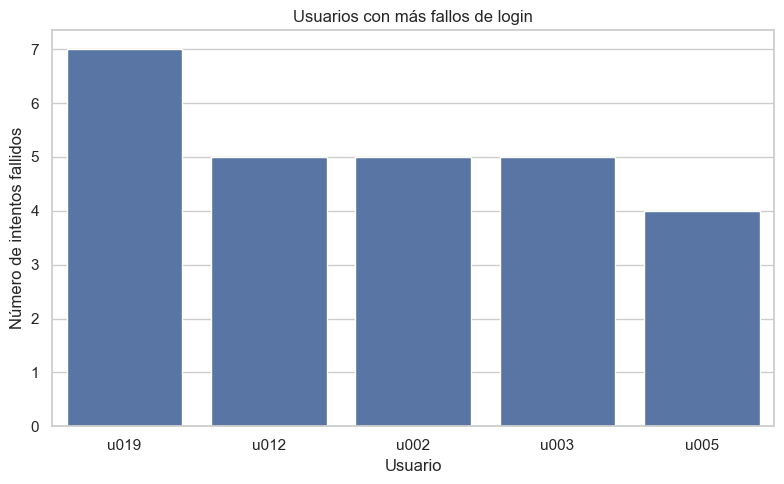

In [8]:
# Filtrar accesos fallidos
fallos_login = accesos[accesos['action'] == 'failed_login']

# Total de intentos fallidos
print(f"Total de intentos de login fallidos: {len(fallos_login)}")

# Top 5 usuarios con más fallos
top_fallos = fallos_login['user_id'].value_counts().head()
print("\nUsuarios con más fallos de login:")
print(top_fallos)

# Gráfico de los usuarios con más intentos fallidos
plt.figure(figsize=(8,5))
sns.barplot(x=top_fallos.index, y=top_fallos.values)
plt.title('Usuarios con más fallos de login')
plt.xlabel('Usuario')
plt.ylabel('Número de intentos fallidos')
plt.tight_layout()
plt.show()


### Interpretación de hallazgos

Se han registrado un total de **61 intentos fallidos de inicio de sesión**, lo cual representa aproximadamente el 20 % del total de eventos analizados.

Los usuarios con más fallos son:
- `u019`: 7 fallos
- `u012`: 5 fallos *(este usuario también fue identificado como inactivo con actividad)*
- `u002`, `u003`: 5 fallos cada uno
- `u005`: 4 fallos

Estos patrones pueden deberse a intentos legítimos por parte de los usuarios o a posibles intentos no autorizados de acceso a cuentas. La coincidencia de `u012` en este análisis y en el anterior refuerza la necesidad de investigar esa cuenta de forma prioritaria.

📌 **Recomendación:**  
- Revisar la frecuencia de fallos por usuario e IP.  
- Habilitar bloqueo temporal tras múltiples intentos fallidos.  
- Establecer alertas automáticas cuando un usuario supere cierto umbral de errores consecutivos.


## Conclusiones finales y recomendaciones globales

Este análisis simulado ha permitido identificar riesgos relevantes en el sistema de accesos, utilizando datos ficticios y un enfoque propio de auditoría IT. A través del procesamiento y visualización de los datos se han extraído hallazgos que reflejan buenas prácticas, así como posibles puntos débiles en el control interno.

### Principales hallazgos:
- **42 % de accesos** ocurrieron fuera del horario laboral habitual.
- El usuario `u012` ha generado **actividad significativa estando inactivo**, lo que representa un riesgo crítico.
- Se registraron **61 fallos de inicio de sesión**, algunos concentrados en usuarios específicos, lo que podría indicar errores recurrentes o intentos de acceso indebido.

### Recomendaciones globales:
1. **Revisar el ciclo de vida de cuentas**: asegurar el cierre efectivo de cuentas inactivas.
2. **Implementar alertas para accesos anómalos** (por hora, usuario o volumen).
3. **Establecer bloqueos automáticos temporales** tras varios fallos consecutivos de login.
4. **Realizar auditorías periódicas** de accesos, roles y permisos.
5. **Capacitar a los usuarios** sobre el uso correcto de credenciales y prácticas seguras.

---

Este tipo de análisis es una primera aproximación que puede escalarse en entornos reales con integración de logs, herramientas de SIEM, ETLs y dashboards interactivos para los equipos de auditoría y seguridad IT.
